In [1]:
import example1

import numpy as np
import qutip as qt
from qutip.solver.heom import HEOMSolver, UnderDampedBath

import matplotlib.pyplot as plt

In [2]:
ex1 = example1.setup_example()

### Calculation by integrating master equation

In [3]:
liouvillian = -1j * qt.spre(ex1['Htot']) + 1j * qt.spost(ex1['Htot'])
for gamma, L in zip(ex1['rates'], ex1['lindblad_ops']):
    liouvillian += gamma * (qt.spre(L) * qt.spost(L.dag()) - qt.spre(L.dag() * L) / 2 - qt.spost(L.dag() * L) / 2)

mesol = qt.mesolve(liouvillian, ex1['rho0'], example1.TLIST, e_ops=[ex1['Hs'], *ex1['heat_current_ops']],
                   options={'normalize_output': False, 'progress_bar': 'tqdm'})

  0%|          | 0/249 [00:00<?, ?it/s]

### Calculation with HEOM

In [4]:
HEOM_CUTOFF = 15

In [21]:
def bath_heat_current(time, ado_state):
    # copied, modified from qutip-tutorials notebook
    l1_labels = ado_state.filter(level=1)

    result = 0
    for label in l1_labels:
        [exp] = ado_state.exps(label)
        result -= exp.vk * (ex1['Q_system'] * ado_state.extract(label)).tr()

    return np.real(result)

In [18]:
bath = UnderDampedBath(ex1['Q_system'],
                       example1.COUP_STRENGTH, 2 * example1.HALF_WIDTH, example1.BATH_FREQ, 1 / example1.BETA,
                       example1.NUM_MATSUBARA)
solver = HEOMSolver(ex1['Hs_system'], bath, HEOM_CUTOFF,
                    options={'progress_bar': 'tqdm'})

heomsol = solver.run(ex1['rho0_system'], example1.TLIST, e_ops=[ex1['Hs_system'], bath_heat_current])

  0%|          | 0/249 [00:00<?, ?it/s]

### Plots

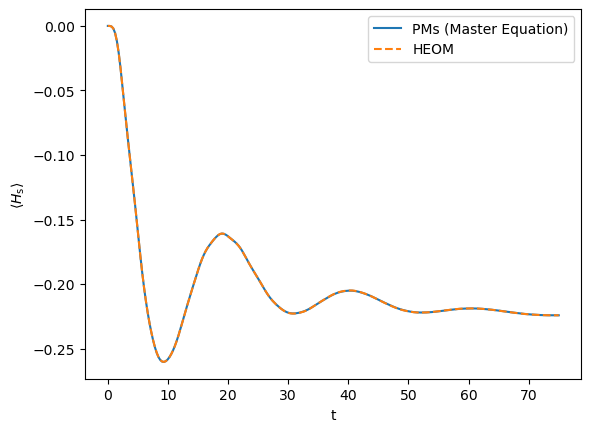

In [19]:
plt.plot(example1.TLIST, mesol.expect[0], label='PMs (Master Equation)')
plt.plot(example1.TLIST, heomsol.expect[0], '--', label='HEOM')
plt.xlabel('t')
plt.ylabel(r'$\langle H_{\text{s}} \rangle$')

plt.legend()
plt.show()

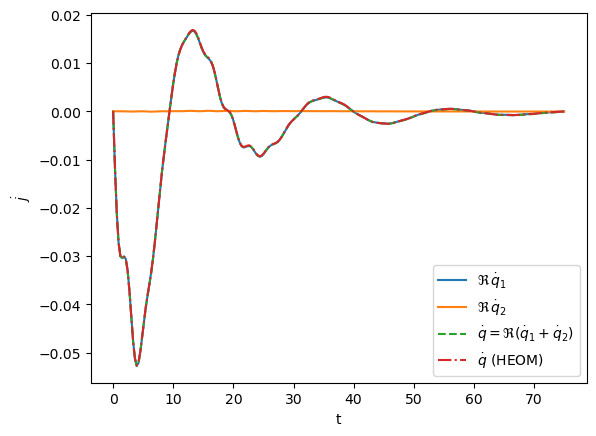

In [26]:
plt.plot(example1.TLIST, np.real(mesol.expect[1]), label=r'$\Re\, \dot q_1$')
plt.plot(example1.TLIST, np.real(mesol.expect[2]), label=r'$\Re\, \dot q_2$')
plt.plot(example1.TLIST, np.real(mesol.expect[1]) + np.real(mesol.expect[2]), '--', label=r'$\dot q = \Re(\dot q_1 + \dot q_2)$')
plt.plot(example1.TLIST, np.real(heomsol.expect[1]), '-.', label=r'$\dot q$ (HEOM)')
plt.xlabel('t')
plt.ylabel(r'$\dot j$')

plt.legend()
plt.show()

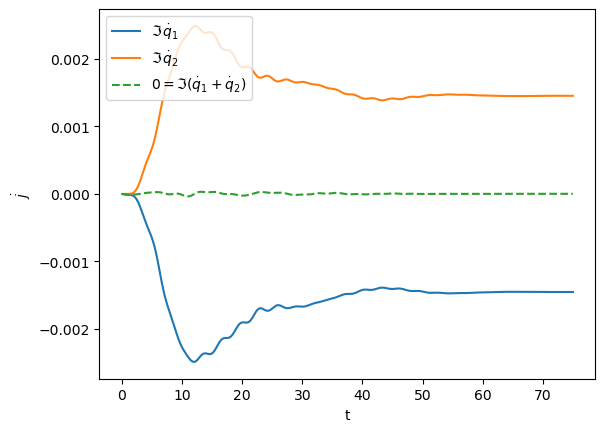

In [9]:
plt.plot(example1.TLIST, np.imag(mesol.expect[1]), label=r'$\Im\, \dot q_1$')
plt.plot(example1.TLIST, np.imag(mesol.expect[2]), label=r'$\Im\, \dot q_2$')
plt.plot(example1.TLIST, np.imag(mesol.expect[1]) + np.imag(mesol.expect[2]), '--', label=r'$0 = \Im(\dot q_1 + \dot q_2)$')
plt.xlabel('t')
plt.ylabel(r'$\dot j$')

plt.legend()
plt.show()

### Trajectories

In [33]:
mcsol1k = qt.qload('../tmp')
mcsol10k = qt.qload('../tmp10k')

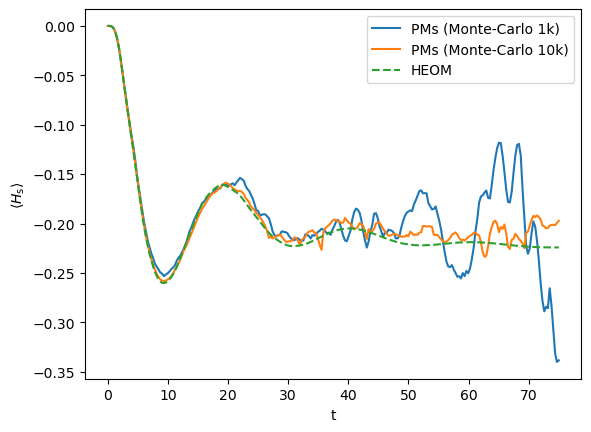

In [34]:
plt.plot(example1.TLIST, np.real(mcsol1k.average_expect[0]), label='PMs (Monte-Carlo 1k)')
plt.plot(example1.TLIST, np.real(mcsol10k.average_expect[0]), label='PMs (Monte-Carlo 10k)')
plt.plot(example1.TLIST, np.real(heomsol.expect[0]), '--', label='HEOM')
plt.xlabel('t')
plt.ylabel(r'$\langle H_{\text{s}} \rangle$')

plt.legend()
plt.show()

In [32]:
mcsol

<PDPResult
  Solver: PDP Solver
  Solver stats:
    method: 'PDP'
    init time: 1.3113021850585938e-05
    preparation time: 0.006963491439819336
    run time: 368.06469917297363
    solver: 'Piecewise Deterministic Process Solver'
    system: '<pdp.pseudomodes.StandardPseudoUnraveling object at 0x7f7c607c5110>'
    end_condition: 'unknown'
  Time interval: [0.0, 75.0] (250 steps)
  Number of e_ops: 1
  State not saved.
  Number of trajectories: 1000
  Trajectories not saved.
>